
# RUN VCE - for all data better in separate script

In [19]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
from tqdm import tqdm
from omegaconf import OmegaConf
import umap
from models import JointLatentDiffusionMultilabel, MultilabelClassifier
from datasets import ChestXRay_nih_bbox
import torchvision as tv
from ldm.util import default
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from einops import rearrange, repeat
from ldm.models.diffusion.ddim import DDIMSampler
import os

os.environ["CUDA_VISIBLE_DEVICES"]="0"
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")



In [20]:
# config = OmegaConf.load("logs/a2_jd_classweight0_001_JointLatentDiffusionMultilabel_2024-02-08T16-53-13/configs/config.yaml")
# config.model.params["ckpt_path"] = f"logs/a2_jd_classweight0_001_JointLatentDiffusionMultilabel_2024-02-08T16-53-13/checkpoints/last.ckpt"

# config = OmegaConf.load("logs/a7_jd_lr10_4_bcew_JointLatentDiffusionMultilabel_2024-02-09T03-14-54/configs/config.yaml")
# config.model.params["ckpt_path"] = f"logs/a7_jd_lr10_4_bcew_JointLatentDiffusionMultilabel_2024-02-09T03-14-54/checkpoints/last.ckpt"

# config = OmegaConf.load("logs/a8_jd_lr10_4_14cls_JointLatentDiffusionMultilabel_2024-02-09T07-02-07/configs/config.yaml")
# config.model.params["ckpt_path"] = f"logs/a8_jd_lr10_4_14cls_JointLatentDiffusionMultilabel_2024-02-09T07-02-07/checkpoints/last.ckpt"

# config = OmegaConf.load("logs/a21_bcews14cls_lr10_4_cllr10_5_clwe10_2_encauto_JointLatentDiffusionMultilabel_2024-03-01T19-12-04-copy/configs/config.yaml")
# config.model.params["ckpt_path"] = f"logs/a21_bcews14cls_lr10_4_cllr10_5_clwe10_2_encauto_JointLatentDiffusionMultilabel_2024-03-01T19-12-04-copy/checkpoints/epoch=000016.ckpt"

config = OmegaConf.load("logs/logs_vce_wacv/joint_diff_20perc_run_j2_p20_33res/config.yaml")
config.model.params["ckpt_path"] = f"/home/jk/Joint-Diffusion-in-Latent-Space/logs/logs_vce_wacv/joint_diff_20perc_run_j2_p20_33res/epoch=000166.ckpt"

model = JointLatentDiffusionMultilabel(**config.model.get("params", dict()))
model.sampling_method='conditional_to_x'
model.to("cuda")
model.eval()



JointLatentDiffusionMultilabel: Running in eps-prediction mode
DiffusionWrapper has 257.73 M params.
Keeping EMAs of 308.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels
Restored from /home/jk/Joint-Diffusion-in-Latent-Space/logs/logs_vce_wacv/encoder/c16_nih_epoch93.ckpt
Training JointLatentDiffusionMultilabel as an unconditional model.
Keeping EMAs of 312.
Restored from /home/jk/Joint-Diffusion-in-Latent-Space/logs/logs_vce_wacv/joint_diff_20perc_run_j2_p20_33res/epoch=000166.ckpt with 0 missing and 0 unexpected keys
[WARNING] AUROC HARDCODED for 14 classes


/home/jk/miniconda3/envs/ldm/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


JointLatentDiffusionMultilabel(
  (model): DiffusionWrapper(
    (diffusion_model): AdjustedUNet(
      (time_embed): Sequential(
        (0): Linear(in_features=256, out_features=1024, bias=True)
        (1): SiLU()
        (2): Linear(in_features=1024, out_features=1024, bias=True)
      )
      (input_blocks): ModuleList(
        (0): TimestepEmbedSequential(
          (0): Conv2d(4, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (1-2): 2 x TimestepEmbedSequential(
          (0): ResBlock(
            (in_layers): Sequential(
              (0): GroupNorm32(32, 256, eps=1e-05, affine=True)
              (1): SiLU()
              (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            )
            (h_upd): Identity()
            (x_upd): Identity()
            (emb_layers): Sequential(
              (0): SiLU()
              (1): Linear(in_features=1024, out_features=256, bias=True)
            )
            (out_layers): Sequen

In [3]:
#currently we dont have external model - I removed it -,-
# torch.set_printoptions(sci_mode=False)
# config = OmegaConf.load("/home/jk/Joint-Diffusion-in-Latent-Space/logs/d14_resnet_aug8_100_MultilabelClassifier_2024-02-08T23-03-18/configs/config.yaml")
# ckpt_path = f"/home/jk/Joint-Diffusion-in-Latent-Space/logs/d14_resnet_aug8_100_MultilabelClassifier_2024-02-08T23-03-18/checkpoints/last.ckpt"

# model_2 = MultilabelClassifier(**config.model.get("params", dict()))
# checkpoint = torch.load(ckpt_path)
# model_2.load_state_dict(checkpoint["state_dict"])
# model_2.to("cuda")
# model_2.eval()

In [4]:
def embed_imgs(model, data_loader, max_samples=10000):
    # Encode all images in the data_laoder using model, and return both images and encodings
    img_list, embed_list, bbox_list, label_list = [], [], [], []

    for imgs, bbox, label in tqdm(data_loader):
        if len(imgs.shape) == 3:
            imgs = imgs[..., None]
        imgs = rearrange(imgs, 'b h w c -> b c h w')

        with torch.no_grad():
            encoder_posterior = model.encode_first_stage(imgs.to(device))
            latent = model.get_first_stage_encoding(encoder_posterior).detach()
            img_list.append(imgs.cpu())
            embed_list.append(latent.cpu())
            bbox_list.append(bbox)
            label_list.append(label)
        if max_samples is not None and len(img_list) >= max_samples:
            break
    return (img_list, embed_list, bbox_list, label_list)

In [5]:
cl_list = ["Atelectasis","Cardiomegaly","Consolidation","Edema","Effusion","Emphysema","Fibrosis", "Hernia","Infiltration", "Mass", "Nodule","Pleural_Thickening","Pneumonia","Pneumothorax","No Finding"]
cl_list_loop=cl_list.copy()
cl_list_loop=["Atelectasis"]

T = 300
gradscale = 500
model.sample_grad_scale=gradscale
num_timesteps = 1000

folder_to_save = f"simple_guidance_maxnoised{T}_gradscale{gradscale}"
folder_to_save=f"/home/jk/Joint-Diffusion-in-Latent-Space/vce_results/{folder_to_save}"

   
os.makedirs(folder_to_save, exist_ok=True)

In [6]:
for class_ in cl_list_loop:
    dataset = ChestXRay_nih_bbox(pick_class=class_)
    if len(dataset)>0:
        print(class_, 'has N samples: ', len(dataset))
        dl = torch.utils.data.DataLoader(dataset, batch_size=min(len(dataset), 4), shuffle=False)

        ret = embed_imgs(model, dl)
        batch = 0
        x_samples_save = []
        img_original_save = []
        pred_o_save = []
        pred_o_ext_save = []
        pred_ext_save = []
        bbox_save = []

        #pick_class = class_
        pick_class = "Cardiomegaly"
        for img_original, z, bbox in zip(ret[0], ret[1], ret[2]):
            # denoise samples
            z = z.to("cuda")
            t = repeat(torch.tensor([T]), '1 -> b', b=len(z))
            t = t.to("cuda").long()
            noise = torch.randn_like(z)
            z_noisy = model.q_sample(x_start=z, t=t, noise=noise)
            shape = z_noisy.shape            
            samples, pred_o = model.p_sample_loop(cond=None, shape = shape, original_img = z, 
                                                return_intermediates=False, x_T=z_noisy, start_T=T, 
                                                pick_class=pick_class, return_pred_o=True)
            x_samples = model.decode_first_stage(samples)
            
            #predictions with external clasisfier
            # img_original = img_original.to("cuda")
            # pred_o_ext = model_2(img_original)
            # pred_ext = model_2(x_samples)
            pred_o_ext = torch.tensor([])
            pred_ext = torch.tensor([])

            x_samples_save.append(x_samples.detach().cpu().clone())
            del x_samples
            img_original_save.append(img_original.detach().cpu().clone())
            del img_original
            pred_o_save.append(pred_o.detach().cpu().clone())
            del pred_o
            pred_o_ext_save.append(pred_o_ext.detach().cpu().clone())
            del pred_o_ext
            pred_ext_save.append(pred_ext.detach().cpu().clone())
            del pred_ext
            bbox_save.append(bbox.clone())
            del bbox


            batch+=1
            if batch>0:
                break
            
        torch.save(torch.cat(x_samples_save, dim=0), f'{folder_to_save}/{class_}_x_samples.pt')
        del x_samples_save
        torch.save(torch.cat(img_original_save, dim=0), f'{folder_to_save}/{class_}_img_original.pt')
        del img_original_save
        torch.save(torch.cat(pred_o_save, dim=0), f'{folder_to_save}/{class_}_pred_o.pt')
        del pred_o_save
        torch.save(torch.cat(pred_o_ext_save, dim=0), f'{folder_to_save}/{class_}_pred_o_ext.pt')
        del pred_o_ext_save
        torch.save(torch.cat(pred_ext_save, dim=0), f'{folder_to_save}/{class_}_pred_ext.pt')
        del pred_ext_save
        torch.save(torch.cat(bbox_save, dim=0), f'{folder_to_save}/{class_}_bbox.pt')
        del bbox_save

Atelectasis has N samples:  180


100%|██████████| 45/45 [00:05<00:00,  8.58it/s]


[WARNING] models/latent_diffusion/joint_latent_diffusion_multilabel.py, p_sample_loop: return_pred_o not implemented for every case


Sampling t: 100%|██████████| 300/300 [00:44<00:00,  6.79it/s]


['[WARNING] Return_pred_o cannot return intermediates - not impemented!']


# PLOT IMGS

In [7]:
import torch


In [8]:
T = 300
gradscale=500
folder_to_save = f"simple_guidance_maxnoised{T}_gradscale{gradscale}"
folder_to_save=f"/home/jk/Joint-Diffusion-in-Latent-Space/vce_results/{folder_to_save}"

cl_list = ["Atelectasis","Cardiomegaly","Consolidation","Edema","Effusion","Emphysema","Fibrosis", "Hernia","Infiltration", "Mass", "Nodule","Pleural_Thickening","Pneumonia","Pneumothorax","No Finding"]
for class_ in ["Atelectasis"]:
    x_samples =torch.load(f'{folder_to_save}/{class_}_x_samples.pt')
    pred_o = torch.load(f'{folder_to_save}/{class_}_pred_o.pt')
    img_original = torch.load(f'{folder_to_save}/{class_}_img_original.pt')
    pred_o_ext = torch.load(f'{folder_to_save}/{class_}_pred_o_ext.pt')
    pred_ext = torch.load(f'{folder_to_save}/{class_}_pred_ext.pt')
    bbox = torch.load(f'{folder_to_save}/{class_}_bbox.pt')



In [9]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches


IndexError: index 2 is out of bounds for dimension 0 with size 0

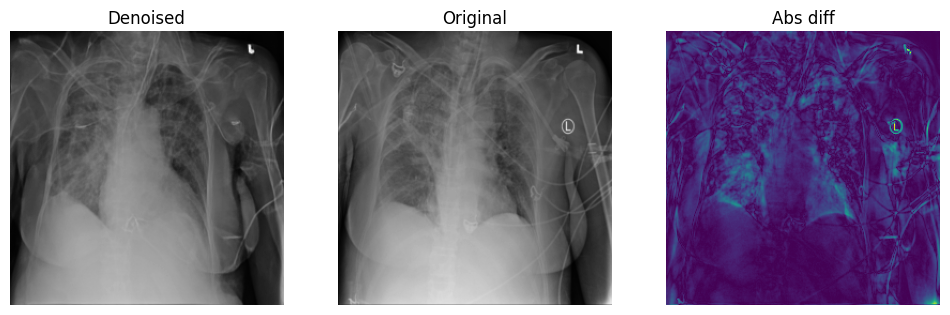

In [18]:
idx_from_batch = 2

fig, axes = plt.subplots(1, 3, figsize=(12, 4))


# Plot the images on the subplots
denoised_guided_normalized = x_samples.cpu()[idx_from_batch].permute(1,2,0)
denoised_guided = denoised_guided_normalized*0.5+0.5
img_ref_normalized = img_original.cpu()[idx_from_batch].permute(1,2,0)
img_ref = img_ref_normalized*0.5+0.5
diff = abs(denoised_guided - img_ref)

ax = 0
axes[ax].imshow(denoised_guided, cmap='gray')
axes[ax].axis('off')
axes[ax].set_title("Denoised")

ax +=1
axes[ax].imshow(img_ref, cmap='gray')
axes[ax].axis('off')
axes[ax].set_title("Original")

ax +=1


x, y, w, h = bbox[idx_from_batch][0], bbox[idx_from_batch][1],bbox[idx_from_batch][2], bbox[idx_from_batch][3]
# Scale the bounding box coordinates from 1024x1024 to 256x256
scaled_x = x * 0.25
scaled_y = y * 0.25
scaled_w = w * 0.25
scaled_h = h * 0.25

# Create a rectangle patch using the scaled coordinates
rect = patches.Rectangle((scaled_x, scaled_y), scaled_w, scaled_h, linewidth=1, edgecolor='r', facecolor='none')

# Add the rectangle patch to the plot
#axes[ax].add_patch(rect)


axes[ax].imshow(diff)
axes[ax].axis('off')
axes[ax].set_title("Abs diff")


#fig.suptitle(ret[3][0][idx_from_batch])
pred_o_for_item = torch.nn.functional.sigmoid(pred_o[idx_from_batch])
pred_o_ext_for_item = torch.nn.functional.sigmoid(pred_o_ext[idx_from_batch])
pred_ext_for_item = torch.nn.functional.sigmoid(pred_ext[idx_from_batch])
id_class = cl_list.index(class_)
print('all predictins for orig x', pred_o_ext_for_item)
print('all predictins for x pred start', pred_ext_for_item)
print(f'predicitons for x original JOINT, only class {cl_list[id_class]}', pred_o_for_item[id_class])
print(f'predicitons for x original EXT, only class {cl_list[id_class]}', pred_o_ext_for_item[id_class])
print(f'predicitons for x pred start EXT, only class {cl_list[id_class]}',pred_ext_for_item[id_class])



# TABLES

## Compare mean prediction change for all classes.   
### In index we have class to remove from image. In columns we have mean for (pred_remove_class-pred_orig). Predictions are for EXTERNAL clasisfier. 

In [ ]:
import pandas
import torch

In [ ]:
T = 200
gradscale=300
folder_to_save = f"simple_guidance_maxnoised{T}_gradscale{gradscale}"
folder_to_save=f"/home/jk/Joint-Diffusion-in-Latent-Space/vce_results/{folder_to_save}"


min_prediction_confidence = 0.0
cl_list = ["Atelectasis","Cardiomegaly","Consolidation","Edema","Effusion","Emphysema","Fibrosis", "Hernia","Infiltration", "Mass", "Nodule","Pleural_Thickening","Pneumonia","Pneumothorax","No Finding"]
indexes = []
data = []
for cl_index, class_ in enumerate(cl_list):
    try:
        x_samples =torch.load(f'{folder_to_save}/{class_}_x_samples.pt')
        pred_o = torch.load(f'{folder_to_save}/{class_}_pred_o.pt')
        img_original = torch.load(f'{folder_to_save}/{class_}_img_original.pt')
        pred_o_ext = torch.load(f'{folder_to_save}/{class_}_pred_o_ext.pt')
        pred_ext = torch.load(f'{folder_to_save}/{class_}_pred_ext.pt')
        bbox = torch.load(f'{folder_to_save}/{class_}_bbox.pt')
        
        mask = torch.nn.functional.sigmoid(pred_o_ext[:, cl_index])>=min_prediction_confidence
        
        diff = ((torch.nn.functional.sigmoid(pred_ext[mask])-(torch.nn.functional.sigmoid(pred_o_ext[mask])))/1).mean(dim=0)
        indexes.append(class_)
        data.append(diff)
    except:
       pass

print(f"Denoising timestep {T}, min_prediction_confidence {min_prediction_confidence}")
df=pandas.DataFrame(data, columns=cl_list, index=indexes)
df= df.applymap(lambda x: x.item())
df.style.highlight_max(color = 'lightgreen', axis = 1) 


Denoising timestep 200, min_prediction_confidence 0.0


,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,No Finding


## Compare predictions only for denoised class

In [ ]:
T = 200
gradscale=300
folder_to_save = f"simple_guidance_maxnoised{T}_gradscale{gradscale}"
folder_to_save=f"/home/jk/Joint-Diffusion-in-Latent-Space/vce_results/{folder_to_save}"

min_prediction_confidence = 0.0
cl_list = ["Atelectasis","Cardiomegaly","Consolidation","Edema","Effusion","Emphysema","Fibrosis", "Hernia","Infiltration", "Mass", "Nodule","Pleural_Thickening","Pneumonia","Pneumothorax","No Finding"]
folder_to_save='vce_scale0'
indexes = []
data = []
for cl_index, class_ in enumerate(cl_list):
    try:
        x_samples =torch.load(f'{folder_to_save}/{class_}_x_samples.pt')
        pred_o = torch.load(f'{folder_to_save}/{class_}_pred_o.pt')
        img_original = torch.load(f'{folder_to_save}/{class_}_img_original.pt')
        pred_o_ext = torch.load(f'{folder_to_save}/{class_}_pred_o_ext.pt')
        pred_ext = torch.load(f'{folder_to_save}/{class_}_pred_ext.pt')
        bbox = torch.load(f'{folder_to_save}/{class_}_bbox.pt')
        
        mask = torch.nn.functional.sigmoid(pred_o_ext[:, cl_index])>=min_prediction_confidence
        pred_o_ext_class = torch.nn.functional.sigmoid(pred_o_ext[:, cl_index])[mask].mean()
        pred_ext_class = torch.nn.functional.sigmoid(pred_ext[:, cl_index])[mask].mean()
        
        diff = (pred_ext_class-pred_o_ext_class)
        diff_perc = ((pred_ext_class-pred_o_ext_class)/pred_o_ext_class)*100
        n_samples = mask.sum()
        indexes.append(class_)
        data.append([pred_o_ext_class, pred_ext_class, diff, diff_perc, n_samples])
    except:
        pass

print(f"Denoising timestep {T}, min_prediction_confidence {min_prediction_confidence}")
df=pandas.DataFrame(data, columns=["mean_orig_pred", "mean_denoised_pred","abs diff", "perc diff", "n_samples"], index=indexes)
df= df.applymap(lambda x: x.item())
df#.style.highlight_min(color = 'lightgreen', axis = 0) 

Denoising timestep 200, min_prediction_confidence 0.0


,mean_orig_pred,mean_denoised_pred,abs diff,perc diff,n_samples
